In [24]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input

from tqdm import tqdm

# Set image size and other parameters
img_size = 128
dataset_path = r"C:\Users\athit\Downloads\GrapeVine\Grapevine_Leaves_Image_Dataset"  # Change this to your dataset path
train_split = 0.8  # 80% for training, 20% for testing

# Step 1: Organize data into train/test folders
def split_dataset(source_dir, dest_dir, split_ratio=0.8):
    # Iterate through each class subdirectory
    for class_name in os.listdir(source_dir):
        class_dir = os.path.join(source_dir, class_name)
        if os.path.isdir(class_dir):
            # Create train and test subdirectories for the class
            os.makedirs(os.path.join(dest_dir, 'train', class_name), exist_ok=True)
            os.makedirs(os.path.join(dest_dir, 'test', class_name), exist_ok=True)
            
            # Get all image file paths in this class
            image_paths = [os.path.join(class_dir, filename) for filename in os.listdir(class_dir) if filename.endswith(('.jpg', '.png'))]
            
            # Split the images into train and test sets
            train_paths, test_paths = train_test_split(image_paths, test_size=1 - split_ratio, random_state=42)

            # Move the images to their respective folders
            for train_path in tqdm(train_paths, desc=f"Processing {class_name} train set"):
                shutil.copy(train_path, os.path.join(dest_dir, 'train', class_name))
            for test_path in tqdm(test_paths, desc=f"Processing {class_name} test set"):
                shutil.copy(test_path, os.path.join(dest_dir, 'test', class_name))

# Step 2: Manually split the dataset (you only need to run this once)
# Make sure the source dataset is under 'path_to_your_grapevine_leaf_dataset'
split_dataset(os.path.join(dataset_path, 'images'), dataset_path)

Processing Nazli test set: 100%|██████████████████████████████████████████████████████| 20/20 [00:00<00:00, 682.27it/s]


ValueError: With n_samples=0, test_size=0.19999999999999996 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

In [23]:
# Step 3: Create ImageDataGenerators for train and test
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    os.path.join(dataset_path, 'train'),
    target_size=(img_size, img_size),
    batch_size=32,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    os.path.join(dataset_path, 'test'),
    target_size=(img_size, img_size),
    batch_size=32,
    class_mode='categorical')

# Step 4: Create and compile the CNN model
model = models.Sequential([
    Input(shape=(img_size, img_size, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(train_generator.num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Step 5: Train the model
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=test_generator
)

# Step 6: Evaluate the model and print classification report
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc}")
print(f"Test Loss: {test_loss}")

# Get predictions on the test set
y_pred = model.predict(test_generator)
y_true = test_generator.classes
y_pred_classes = np.argmax(y_pred, axis=1)

print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=train_generator.class_indices.keys()))

# Step 7: Visualize feature maps
def visualize_feature_map(model, image):
    # Get the first convolutional layer's output (feature map)
    layer_outputs = [layer.output for layer in model.layers[:5]]  # Can visualize more layers
    activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
    
    # Add an extra dimension for batch size since we are passing a single image
    image = np.expand_dims(image, axis=0)
    
    # Get activations (feature maps)
    activations = activation_model.predict(image)
    
    # Plot feature maps for the first convolutional layer
    first_layer_activation = activations[0]
    num_filters = first_layer_activation.shape[-1]
    
    # Set up the grid for subplots
    size = first_layer_activation.shape[1]
    grid_size = int(np.sqrt(num_filters))
    
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(12, 12))
    
    for i in range(grid_size * grid_size):
        ax = axes[i // grid_size, i % grid_size]
        ax.imshow(first_layer_activation[0, :, :, i], cmap='viridis')
        ax.axis('off')
    
    plt.show()

# Example usage: Take the first image from test set
image = test_generator[0][0][0]  # Get first image from test set
# Force model to build by calling it on a dummy input
_ = model.predict(np.expand_dims(image, axis=0))
visualize_feature_map(model, image)

Found 400 images belonging to 6 classes.
Found 100 images belonging to 6 classes.
Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 832ms/step - accuracy: 0.1786 - loss: 1.7267 - val_accuracy: 0.2800 - val_loss: 1.6085
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 731ms/step - accuracy: 0.2439 - loss: 1.6186 - val_accuracy: 0.2400 - val_loss: 1.6360
Epoch 3/10
 9/13 ━━━━━━━━━━━━━━━━━━━━ 2s 577ms/step - accuracy: 0.2281 - loss: 1.6367

UnknownError: Graph execution error:

Detected at node PyFunc defined at (most recent call last):
<stack traces unavailable>
FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\athit\\Downloads\\GrapeVine\\Grapevine_Leaves_Image_Dataset\\train\\Ak\\Ak (80).png'
Traceback (most recent call last):

  File "C:\Users\athit\miniconda3\envs\jupyter_env\lib\site-packages\tensorflow\python\ops\script_ops.py", line 269, in __call__
    ret = func(*args)

  File "C:\Users\athit\miniconda3\envs\jupyter_env\lib\site-packages\tensorflow\python\autograph\impl\api.py", line 643, in wrapper
    return func(*args, **kwargs)

  File "C:\Users\athit\miniconda3\envs\jupyter_env\lib\site-packages\tensorflow\python\data\ops\from_generator_op.py", line 198, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "C:\Users\athit\miniconda3\envs\jupyter_env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py", line 248, in _finite_generator
    yield self._standardize_batch(self.py_dataset[i])

  File "C:\Users\athit\miniconda3\envs\jupyter_env\lib\site-packages\keras\src\legacy\preprocessing\image.py", line 68, in __getitem__
    return self._get_batches_of_transformed_samples(index_array)

  File "C:\Users\athit\miniconda3\envs\jupyter_env\lib\site-packages\keras\src\legacy\preprocessing\image.py", line 313, in _get_batches_of_transformed_samples
    img = image_utils.load_img(

  File "C:\Users\athit\miniconda3\envs\jupyter_env\lib\site-packages\keras\src\utils\image_utils.py", line 235, in load_img
    with open(path, "rb") as f:

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\athit\\Downloads\\GrapeVine\\Grapevine_Leaves_Image_Dataset\\train\\Ak\\Ak (80).png'


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]] [Op:__inference_multi_step_on_iterator_2303]

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
class_labels = list(train_generator.class_indices.keys())

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# --- Parameters ---
img_size = 128
batch_size = 32
dataset_path = r"C:\Users\Sastra\Downloads\LAB\LAB\GrapeVine\Grapevine_Leaves_Image_Dataset"
split_ratio = 0.8

# --- Step 1: Split the dataset into train/test folders ---
def split_dataset(source_dir, dest_dir, split_ratio=0.8):
    for class_name in os.listdir(source_dir):
        class_dir = os.path.join(source_dir, class_name)
        if os.path.isdir(class_dir):
            os.makedirs(os.path.join(dest_dir, 'train', class_name), exist_ok=True)
            os.makedirs(os.path.join(dest_dir, 'test', class_name), exist_ok=True)

            image_paths = [os.path.join(class_dir, f) for f in os.listdir(class_dir) if f.endswith(('.jpg', '.png'))]
            train_paths, test_paths = train_test_split(image_paths, test_size=1 - split_ratio, random_state=42)

            for path in tqdm(train_paths, desc=f"Train - {class_name}"):
                shutil.copy(path, os.path.join(dest_dir, 'train', class_name))
            for path in tqdm(test_paths, desc=f"Test - {class_name}"):
                shutil.copy(path, os.path.join(dest_dir, 'test', class_name))

# Run only once
# split_dataset(os.path.join(dataset_path, 'images'), dataset_path)

# --- Step 2: Data Generators ---
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    os.path.join(dataset_path, 'train'),
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    os.path.join(dataset_path, 'test'),
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# --- Step 3: Model Definition ---
model = models.Sequential([
    Input(shape=(img_size, img_size, 3)),

    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Dropout(0.3),  # Reduce overfitting

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(train_generator.num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# --- Step 4: Training ---
history = model.fit(train_generator, epochs=15, validation_data=test_generator)

# --- Step 5: Evaluation ---
loss, acc = model.evaluate(test_generator)
print(f"\nTest Accuracy: {acc*100:.2f}%\n")

# --- Step 6: Confusion Matrix & Classification Report ---
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
from PIL import Image
import os
import numpy as np
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
def preprocess(dir,width=150,length=150):
    images=[]
    labels=[]
    label_encoder=LabelEncoder()
    for label in os.listdir(dir):
        label_dir=os.path.join(dir,label)
        if os.path.isdir(label_dir):
            for filename in os.listdir(label_dir):
                if filename.endswith('.jpg') or filename.endswith('.png'):
                    img_path = os.path.join(label_dir,filename)
                    img=Image.open(img_path)
                    img=img.resize((width,length))
                    img=np.array(img) / 255.0
                    labels.append(label)
    
    labels=label_encoder.fit_transform(labels)
    labels = to_categorical(labels,num_classes=len(label_encoder.classes_))
    return np.array(images), np.array(labels)

train_dir=r'C:\Users\Sastra\Downloads\LAB\LAB\GrapeVine\Grapevine_Leaves_Image_Dataset\train'
test_dir=r'C:\Users\Sastra\Downloads\LAB\LAB\GrapeVine\Grapevine_Leaves_Image_Dataset\train'                                  
train_images, train_labels =preprocess(train_dir) 
test_images, test_labels =preprocess(test_dir) 
                                                                      

In [ ]:
model=Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(150,150, 3)),
    Maxpooling2D(2,2),
    Conv2D(64,(3,3),activation='relu'),
    Maxpooling2D(2,2),
    Conv2D(128,(3,3),activation='relu'),
    Maxpooling2D(2,2),
    Conv2D(64,(3,3),activation='relu'),
    Maxpooling2D(2,2),
    Flatten(),
    Dense(512,activation='512'),
    Dense(2,activation='softmax')
])

Epoch 1/15


C:\Users\Sastra\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 406ms/step - accuracy: 0.2260 - loss: 1.6465 - val_accuracy: 0.2800 - val_loss: 1.6050
Epoch 2/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 389ms/step - accuracy: 0.2243 - loss: 1.6038 - val_accuracy: 0.4100 - val_loss: 1.5872
Epoch 3/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 397ms/step - accuracy: 0.3831 - loss: 1.5611 - val_accuracy: 0.3500 - val_loss: 1.4908
Epoch 4/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 389ms/step - accuracy: 0.3656 - loss: 1.4898 - val_accuracy: 0.4400 - val_loss: 1.3483
Epoch 5/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 415ms/step - accuracy: 0.4459 - loss: 1.3473 - val_accuracy: 0.4200 - val_loss: 1.4045
Epoch 6/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 415ms/step - accuracy: 0.4630 - loss: 1.2539 - val_accuracy: 0.4500 - val_loss: 1.2856
Epoch 7/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 382ms/step - accuracy: 0.5652 - loss: 1.0250 - val_accuracy: 0.5000 - val_loss: 1.2869
Epoch 8/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 409ms/step - accuracy: 0.6569 - loss: 0.8671 - val_accuracy: 0.5200 - va

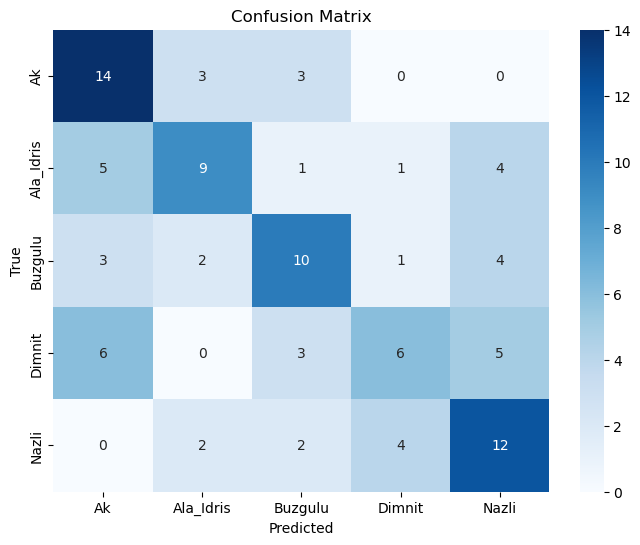

In [32]:
from PIL import Image
import os
import numpy as np
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing function
def preprocess(dir, width=150, length=150):
    images = []
    labels = []
    label_encoder = LabelEncoder()
    
    for label in os.listdir(dir):
        label_dir = os.path.join(dir, label)
        if os.path.isdir(label_dir):
            for filename in os.listdir(label_dir):
                if filename.endswith('.jpg') or filename.endswith('.png'):
                    img_path = os.path.join(label_dir, filename)
                    img = Image.open(img_path).convert('RGB')  # Ensure 3 channels
                    img = img.resize((width, length))
                    img = np.array(img) / 255.0
                    images.append(img)
                    labels.append(label)

    labels = label_encoder.fit_transform(labels)
    labels = to_categorical(labels, num_classes=len(label_encoder.classes_))
    
    return np.array(images), np.array(labels), label_encoder

# Paths
train_dir = r'C:\Users\Sastra\Downloads\LAB\LAB\GrapeVine\Grapevine_Leaves_Image_Dataset\train'
test_dir = r'C:\Users\Sastra\Downloads\LAB\LAB\GrapeVine\Grapevine_Leaves_Image_Dataset\test'

# Load data
train_images, train_labels, label_encoder = preprocess(train_dir)
test_images, test_labels, _ = preprocess(test_dir)

# Model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(512, activation='relu'),
    Dense(train_labels.shape[1], activation='softmax')  # auto match class count
])

# Compile
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train
history = model.fit(train_images, train_labels, epochs=15, validation_data=(test_images, test_labels))

# Evaluation
loss, acc = model.evaluate(test_images, test_labels)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {acc:.4f}")

# Predictions
y_pred = model.predict(test_images)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(test_labels, axis=1)
class_names = label_encoder.classes_

# Classification Report
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [33]:
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_20 (Conv2D)                   │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_20 (MaxPooling2D)      │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_21 (MaxPooling2D)      │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_22 (MaxPooling2D)      │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 15, 15, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_23 (MaxPooling2D)      │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 3136)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 512)                 │       1,606,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 5)                   │           2,565 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,327,249 (20.32 MB)

 Trainable params: 1,775,749 (6.77 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,551,500 (13.55 MB)

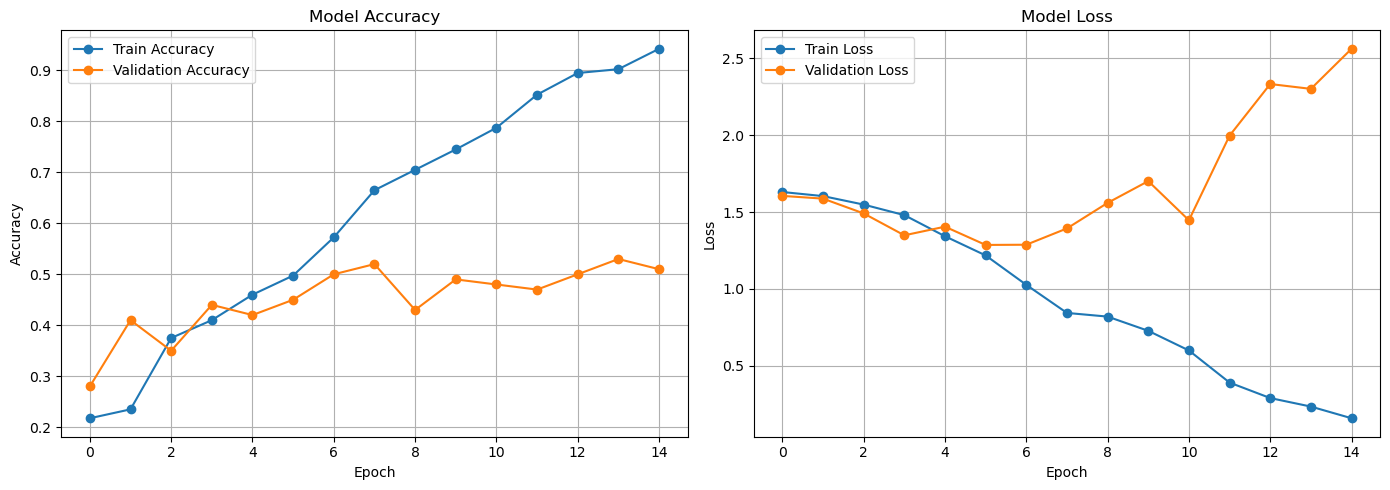

In [34]:
# Plot training & validation accuracy and loss
plt.figure(figsize=(14, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [29]:
# --- Imports ---
import os
import numpy as np
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential

# --- Parameters ---
img_size = 128
batch_size = 32
epochs = 15
base_path = r"C:\Users\athit\Downloads\GrapeVine\Grapevine_Leaves_Image_Dataset"
image_folder = os.path.join(base_path, 'images')
train_folder = os.path.join(base_path, 'train')
test_folder = os.path.join(base_path, 'test')

def prepare_data(image_folder, train_folder, test_folder, test_size=0.2):
    if not os.path.exists(train_folder): os.makedirs(train_folder)
    if not os.path.exists(test_folder): os.makedirs(test_folder)

    for class_name in os.listdir(image_folder):
        class_path = os.path.join(image_folder, class_name)
        if not os.path.isdir(class_path):
            continue

        images = [img for img in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, img))]
        if len(images) < 2:
            print(f"Skipping class '{class_name}' because it has less than 2 images.")
            continue

        train_imgs, test_imgs = train_test_split(images, test_size=test_size, random_state=42)

        os.makedirs(os.path.join(train_folder, class_name), exist_ok=True)
        os.makedirs(os.path.join(test_folder, class_name), exist_ok=True)

        for img in train_imgs:
            shutil.copy(os.path.join(class_path, img), os.path.join(train_folder, class_name, img))
        for img in test_imgs:
            shutil.copy(os.path.join(class_path, img), os.path.join(test_folder, class_name, img))


Found 400 images belonging to 5 classes.
Found 100 images belonging to 5 classes.


C:\Users\athit\miniconda3\envs\jupyter_env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.2317 - loss: 1.8368 - val_accuracy: 0.2000 - val_loss: 1.6062
Epoch 2/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 768ms/step - accuracy: 0.2106 - loss: 1.6052 - val_accuracy: 0.2400 - val_loss: 1.5971
Epoch 3/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 686ms/step - accuracy: 0.2433 - loss: 1.5978 - val_accuracy: 0.2100 - val_loss: 1.5726
Epoch 4/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 627ms/step - accuracy: 0.3105 - loss: 1.5681 - val_accuracy: 0.3300 - val_loss: 1.5732
Epoch 5/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 604ms/step - accuracy: 0.3005 - loss: 1.5797 - val_accuracy: 0.3000 - val_loss: 1.5469
Epoch 6/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 609ms/step - accuracy: 0.3194 - loss: 1.5422 - val_accuracy: 0.2400 - val_loss: 1.5727
Epoch 7/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 636ms/step - accuracy: 0.2846 - loss: 1.5355 - val_accuracy: 0.3100 - val_loss: 1.5307
Epoch 8/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 594ms/step - accuracy: 0.2937 - loss: 1.5410 - val_accuracy: 0.3

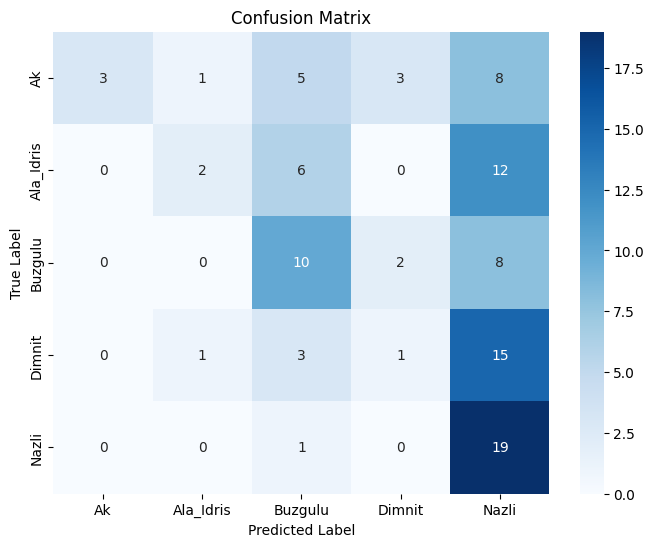

In [30]:
# Call the function to split
prepare_data(image_folder, train_folder, test_folder)

# --- Data Generators ---
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_folder,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_folder,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# --- Model Definition ---
model = Sequential([
    layers.Input(shape=(img_size, img_size, 3)),

    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Dropout(0.3),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(train_generator.num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# --- Training ---
history = model.fit(train_generator, epochs=epochs, validation_data=test_generator)

# --- Evaluation ---
loss, acc = model.evaluate(test_generator)
print(f"\nTest Accuracy: {acc * 100:.2f}%\n")

# --- Confusion Matrix ---
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

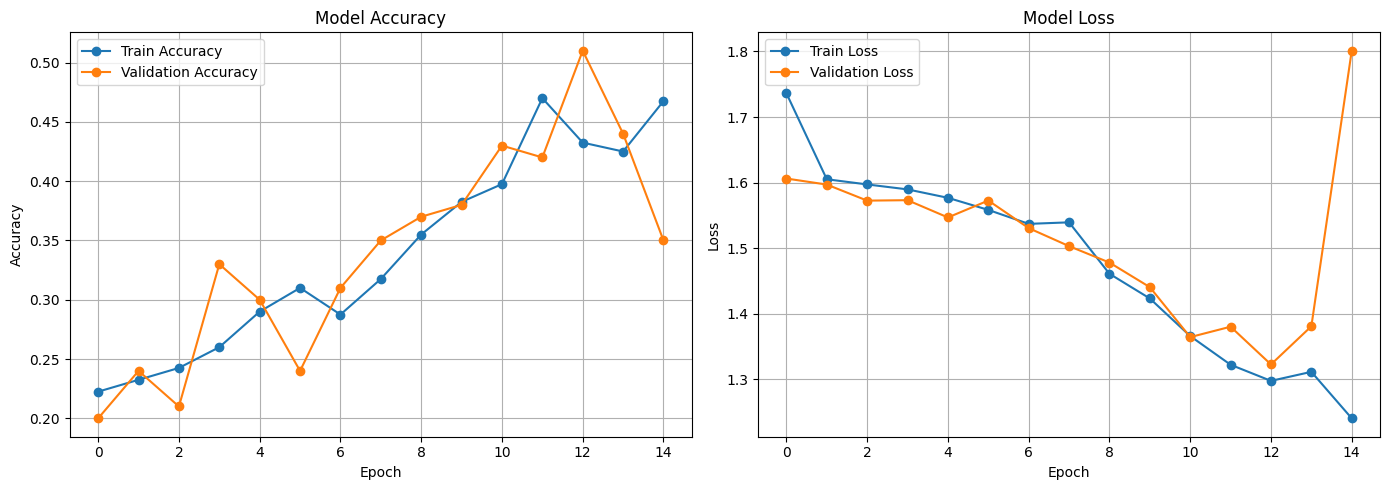

In [31]:
# Plot training & validation accuracy and loss
plt.figure(figsize=(14, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()